[*********************100%%**********************]  4 of 4 completed


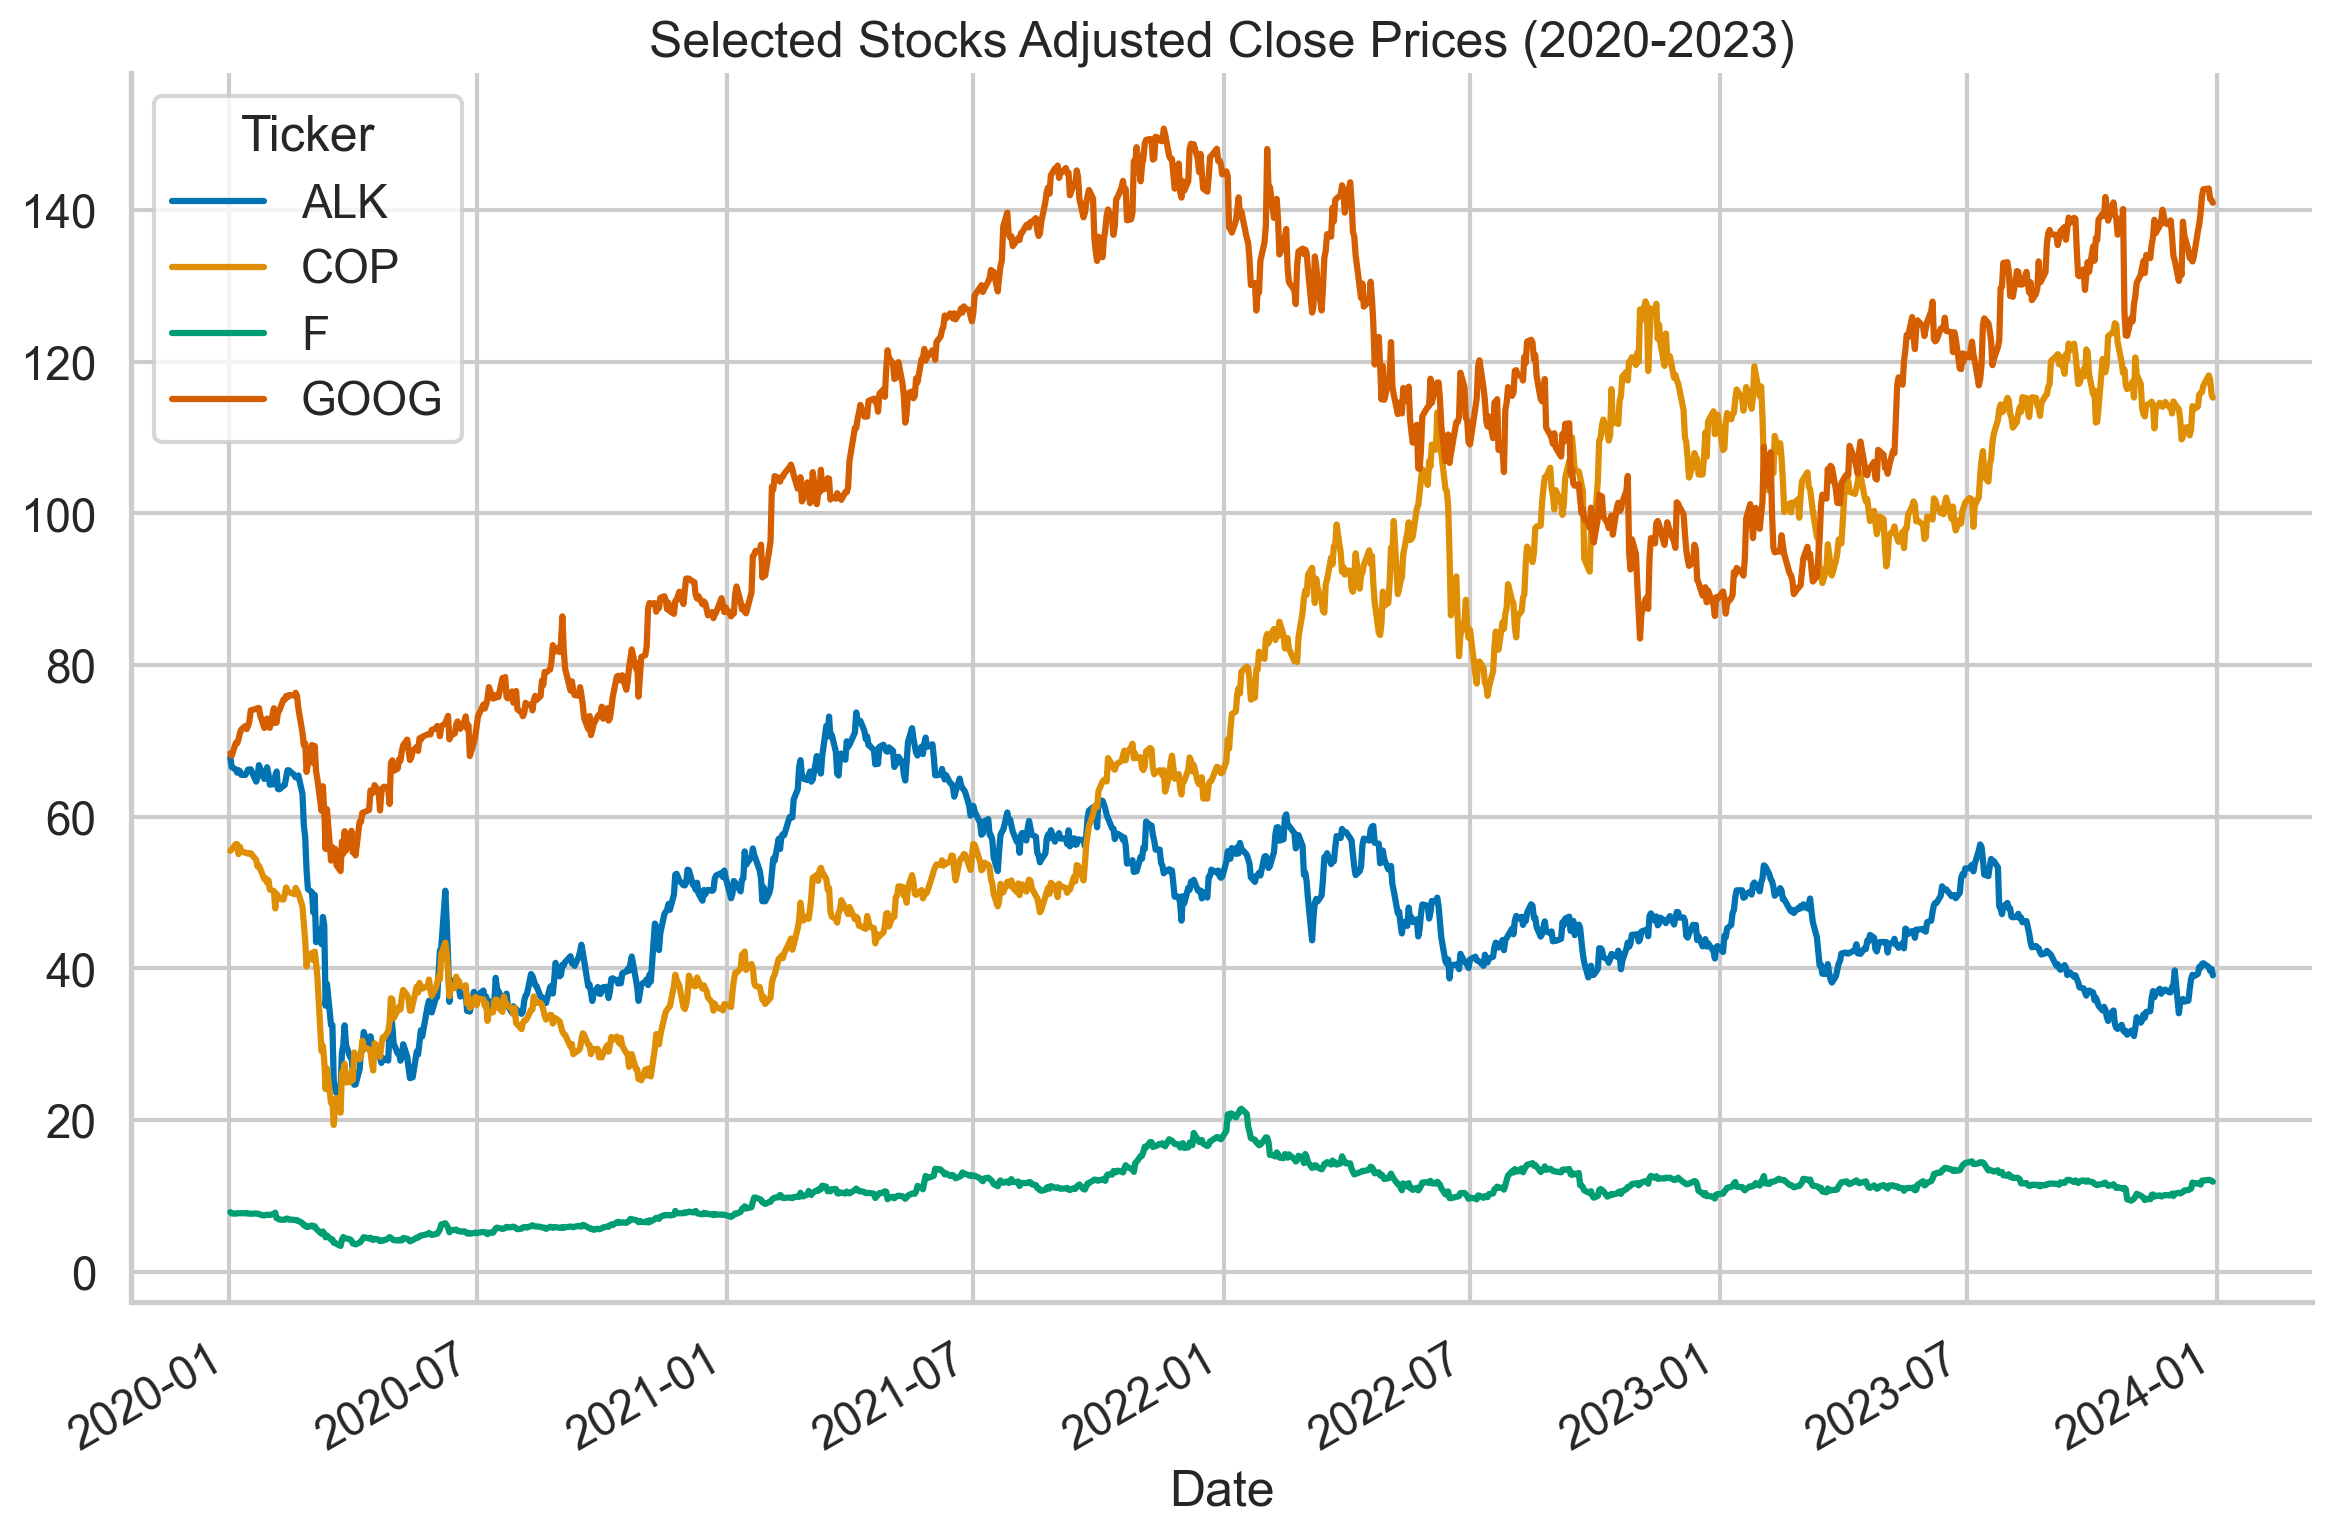

In [6]:
# Import necessary libraries
import warnings
from pandas.errors import SettingWithCopyWarning
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import quantstats as qs

# Suppress warnings for SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

# Adjust plotting style
sns.set_theme(context="talk", style="whitegrid", palette="colorblind", rc={"figure.figsize": [12, 8]})

# Define the assets based on your HW 05 stocks
ASSETS = ["ALK", "GOOG", "COP", "F"]
n_assets = len(ASSETS)

# Fetch stock data from Jan 2020 to Dec 2023
prices_df = yf.download(ASSETS, 
                        start="2020-01-01", 
                        end="2023-12-31", 
                        auto_adjust=False)

# Plot adjusted close prices for selected stocks
prices_df["Adj Close"].plot(title="Selected Stocks Adjusted Close Prices (2020-2023)")
plt.tight_layout()
sns.despine()
plt.show()

# Calculate daily returns
returns = prices_df.pct_change().dropna()

[*********************100%%**********************]  4 of 4 completed


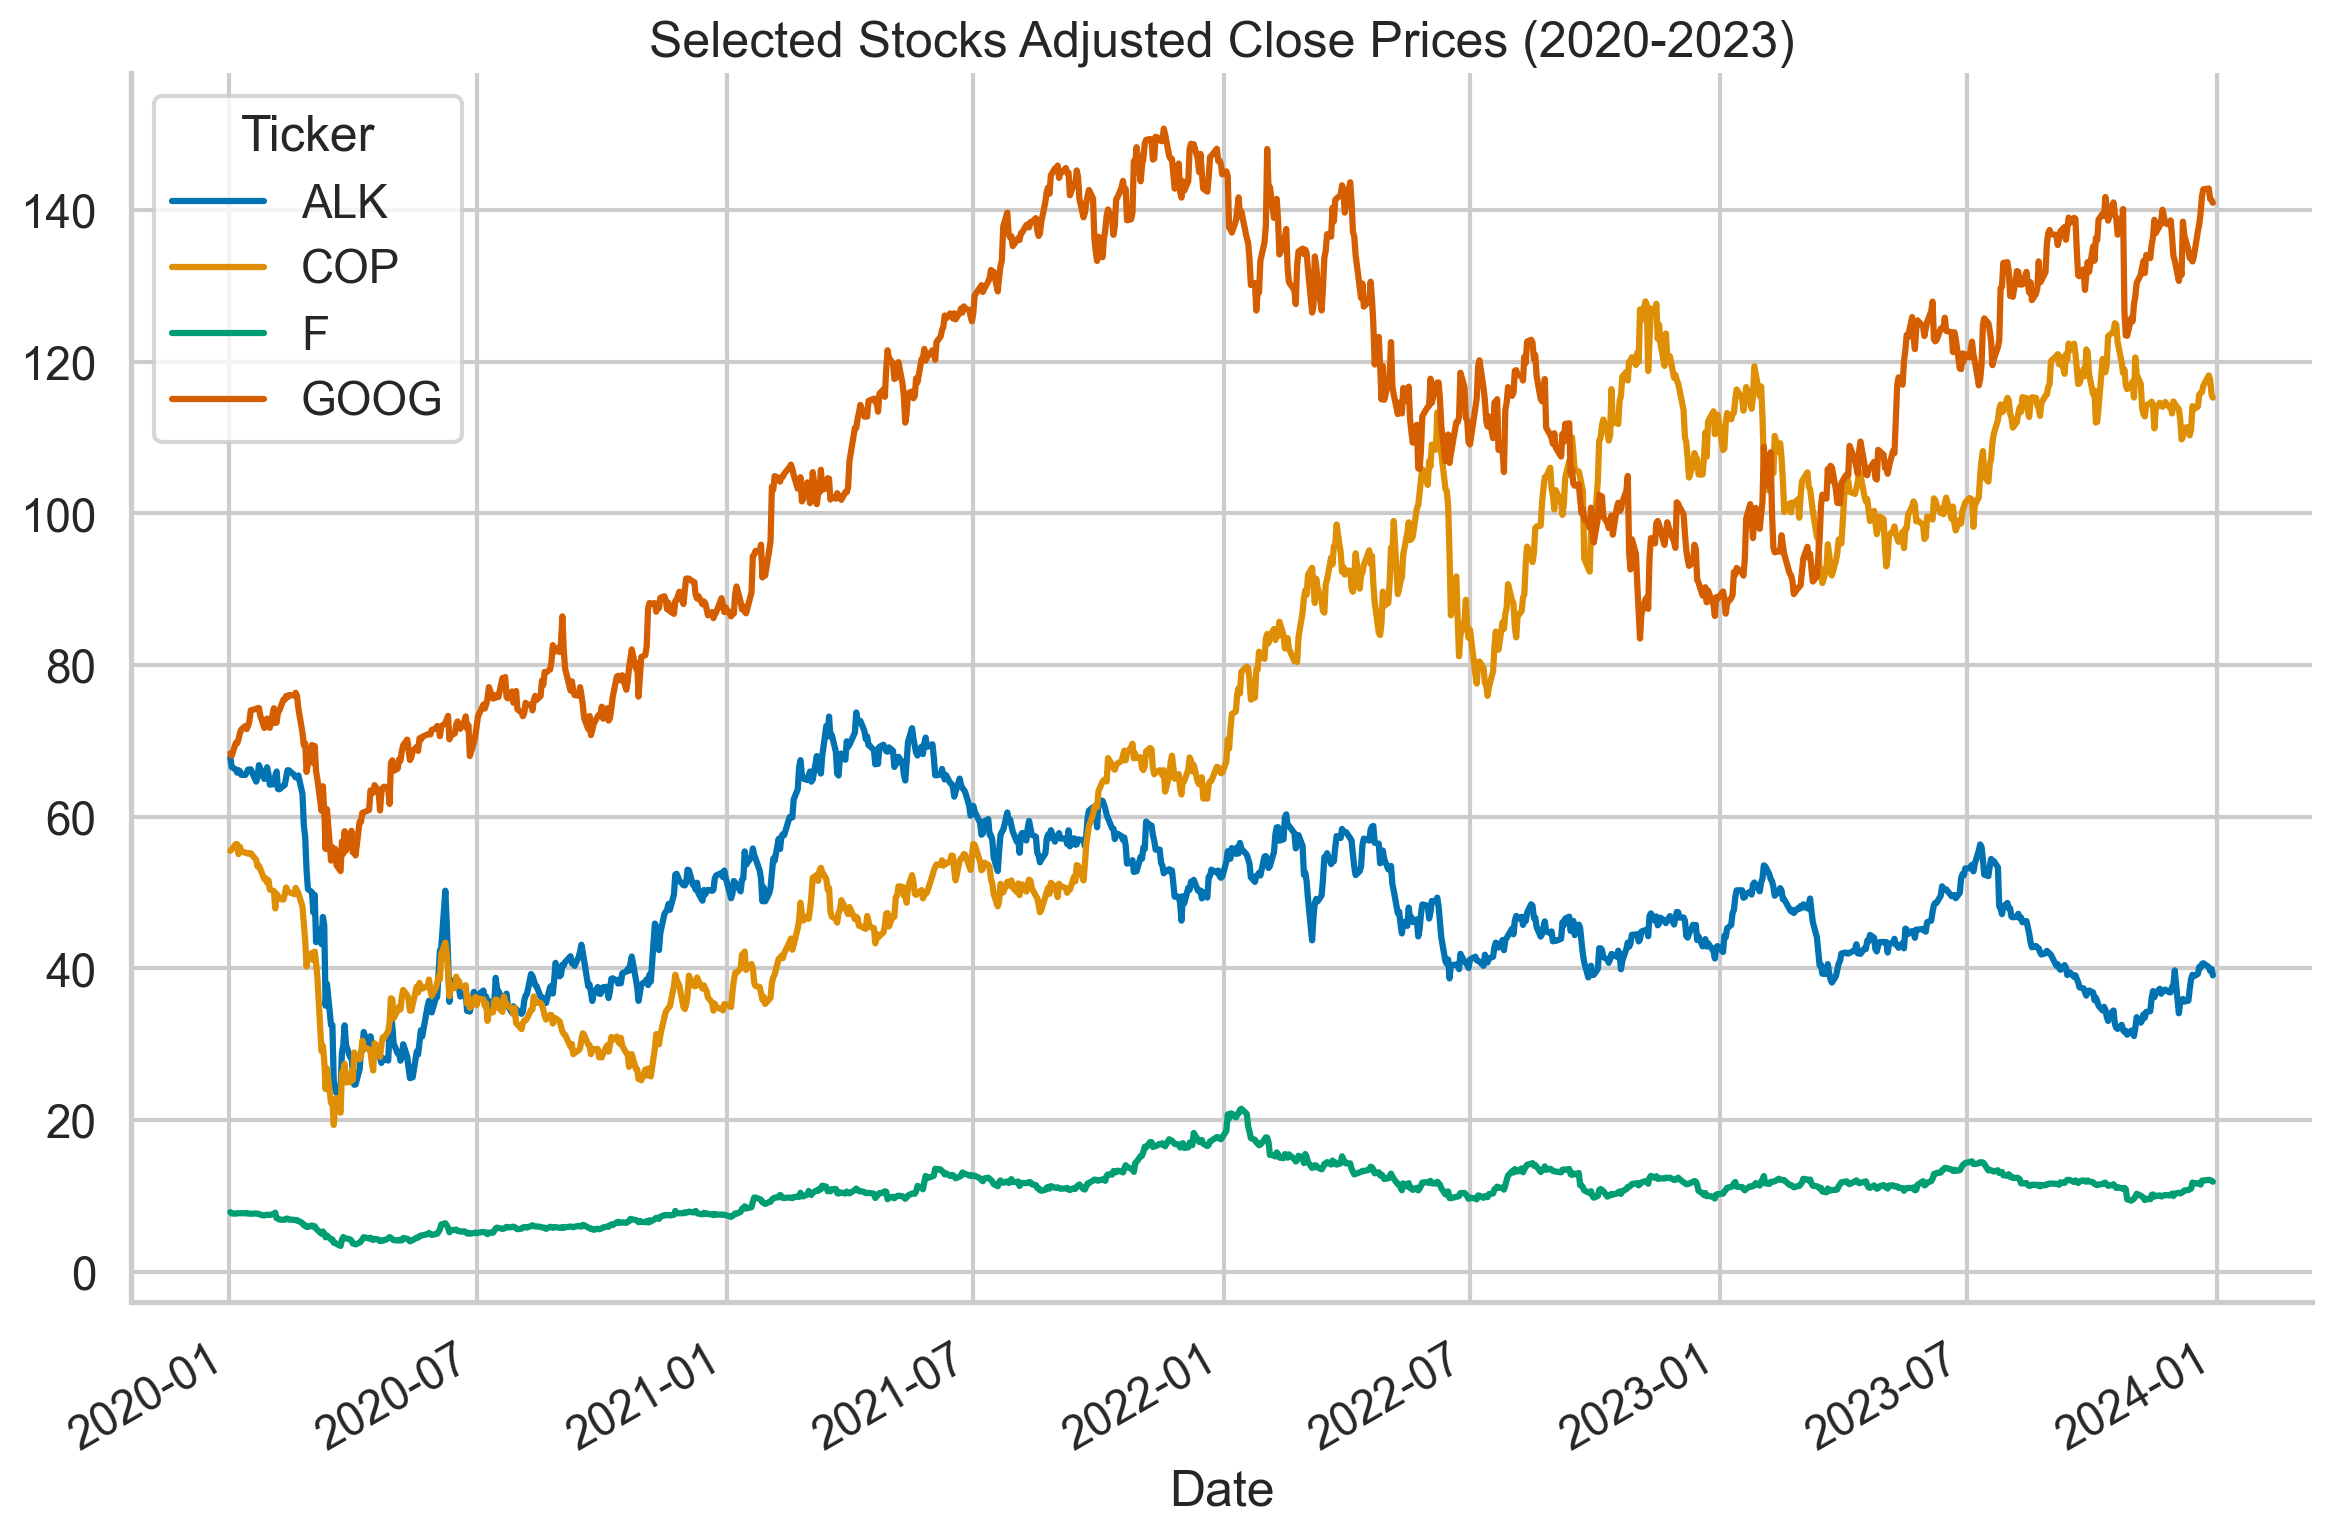

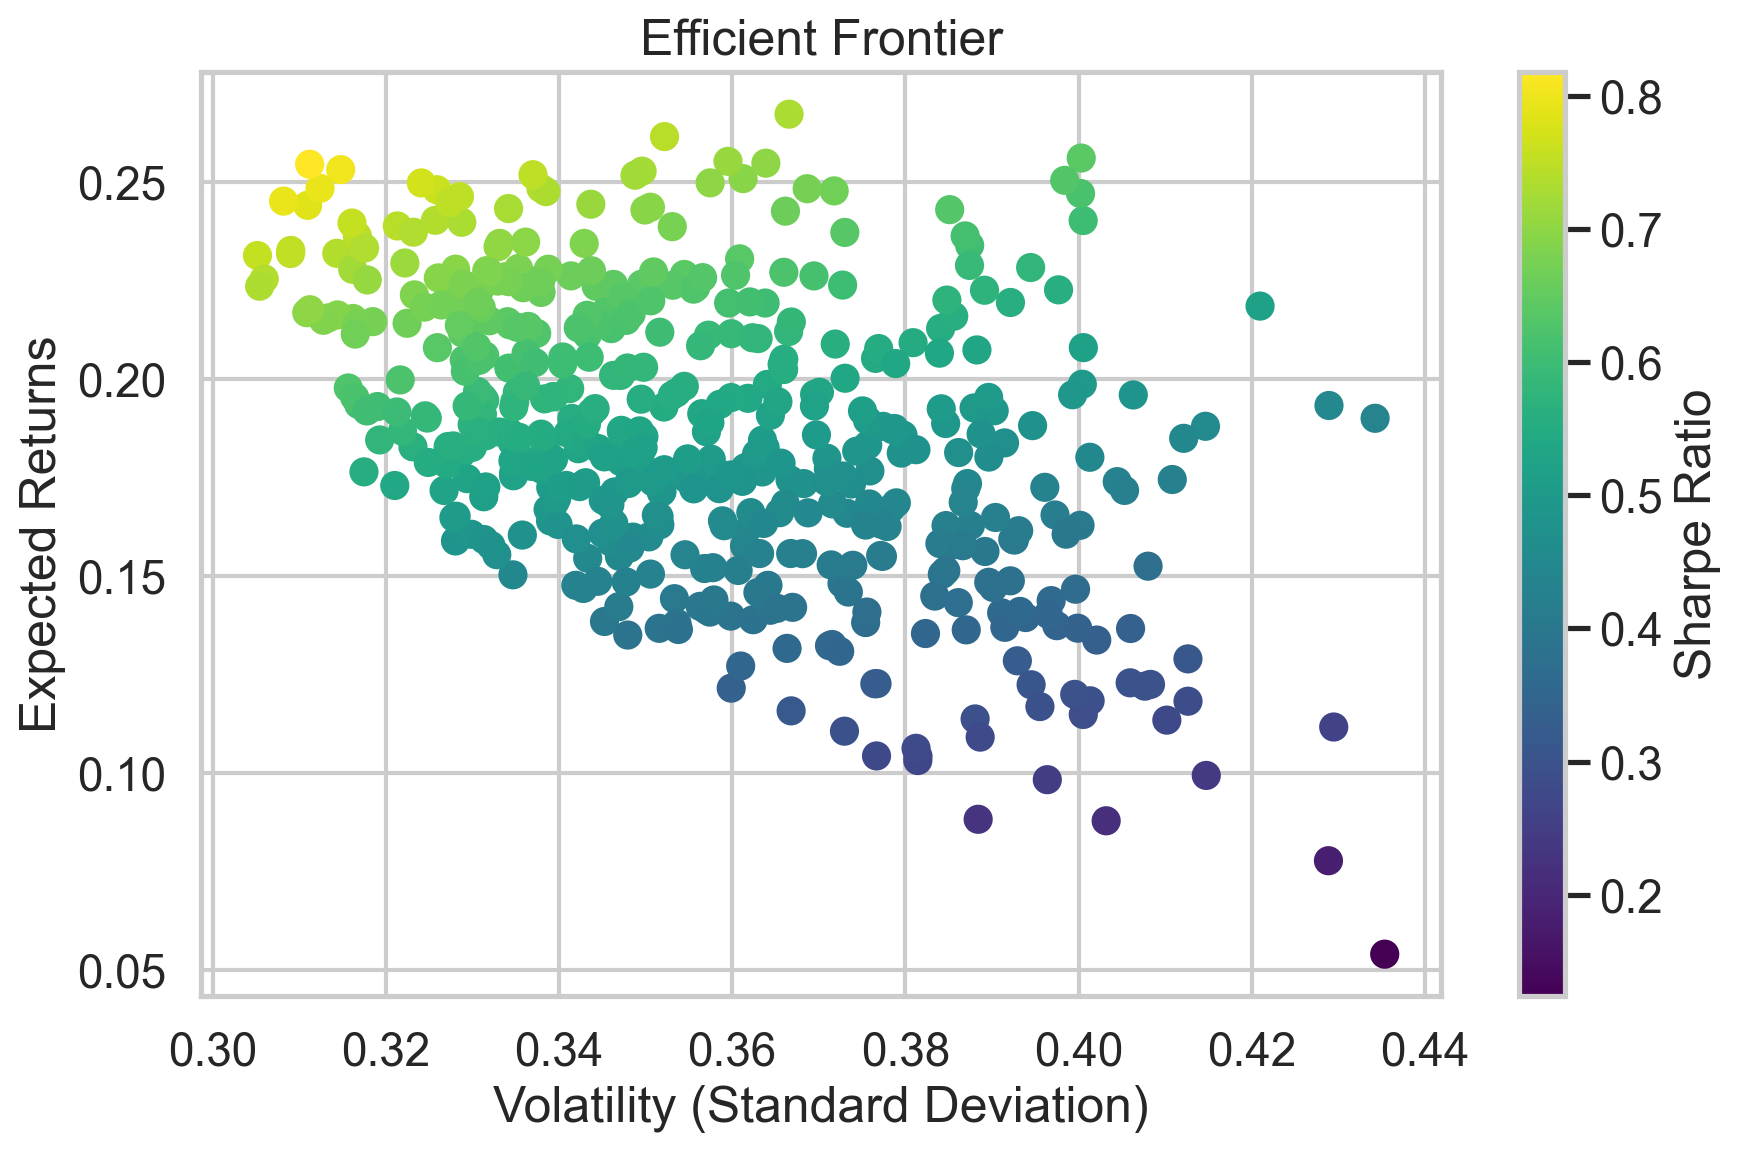

In [7]:
# Fetch stock data from Jan 2020 to Dec 2023
prices_df = yf.download(ASSETS, 
                        start="2020-01-01", 
                        end="2023-12-31", 
                        auto_adjust=False)  # Fetch only adjusted close prices

# Isolate the 'Adj Close' data
adjusted_prices = prices_df['Adj Close']

# Plotting adjusted close prices
adjusted_prices.plot(title="Selected Stocks Adjusted Close Prices (2020-2023)")
plt.tight_layout()
sns.despine()
plt.show()

# Calculate daily returns from adjusted close prices
returns = adjusted_prices.pct_change().dropna()

# Number of portfolios to simulate
num_portfolios = 500
all_weights = np.zeros((num_portfolios, len(ASSETS)))
return_array = np.zeros(num_portfolios)
volatility_array = np.zeros(num_portfolios)
sharpe_array = np.zeros(num_portfolios)

# Simulate portfolios
for i in range(num_portfolios):
    # Generate random weights
    weights = np.random.random(len(ASSETS))
    weights /= np.sum(weights)
    all_weights[i, :] = weights
    
    # Calculate expected portfolio return
    portfolio_return = np.dot(returns.mean() * 252, weights)
    return_array[i] = portfolio_return
    
    # Calculate expected portfolio volatility
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    volatility_array[i] = portfolio_volatility
    
    # Calculate Sharpe ratio (assuming risk-free rate is 0 for simplification)
    sharpe_ratio = portfolio_return / portfolio_volatility
    sharpe_array[i] = sharpe_ratio

# Plotting the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(volatility_array, return_array, c=sharpe_array, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

[*********************100%%**********************]  4 of 4 completed


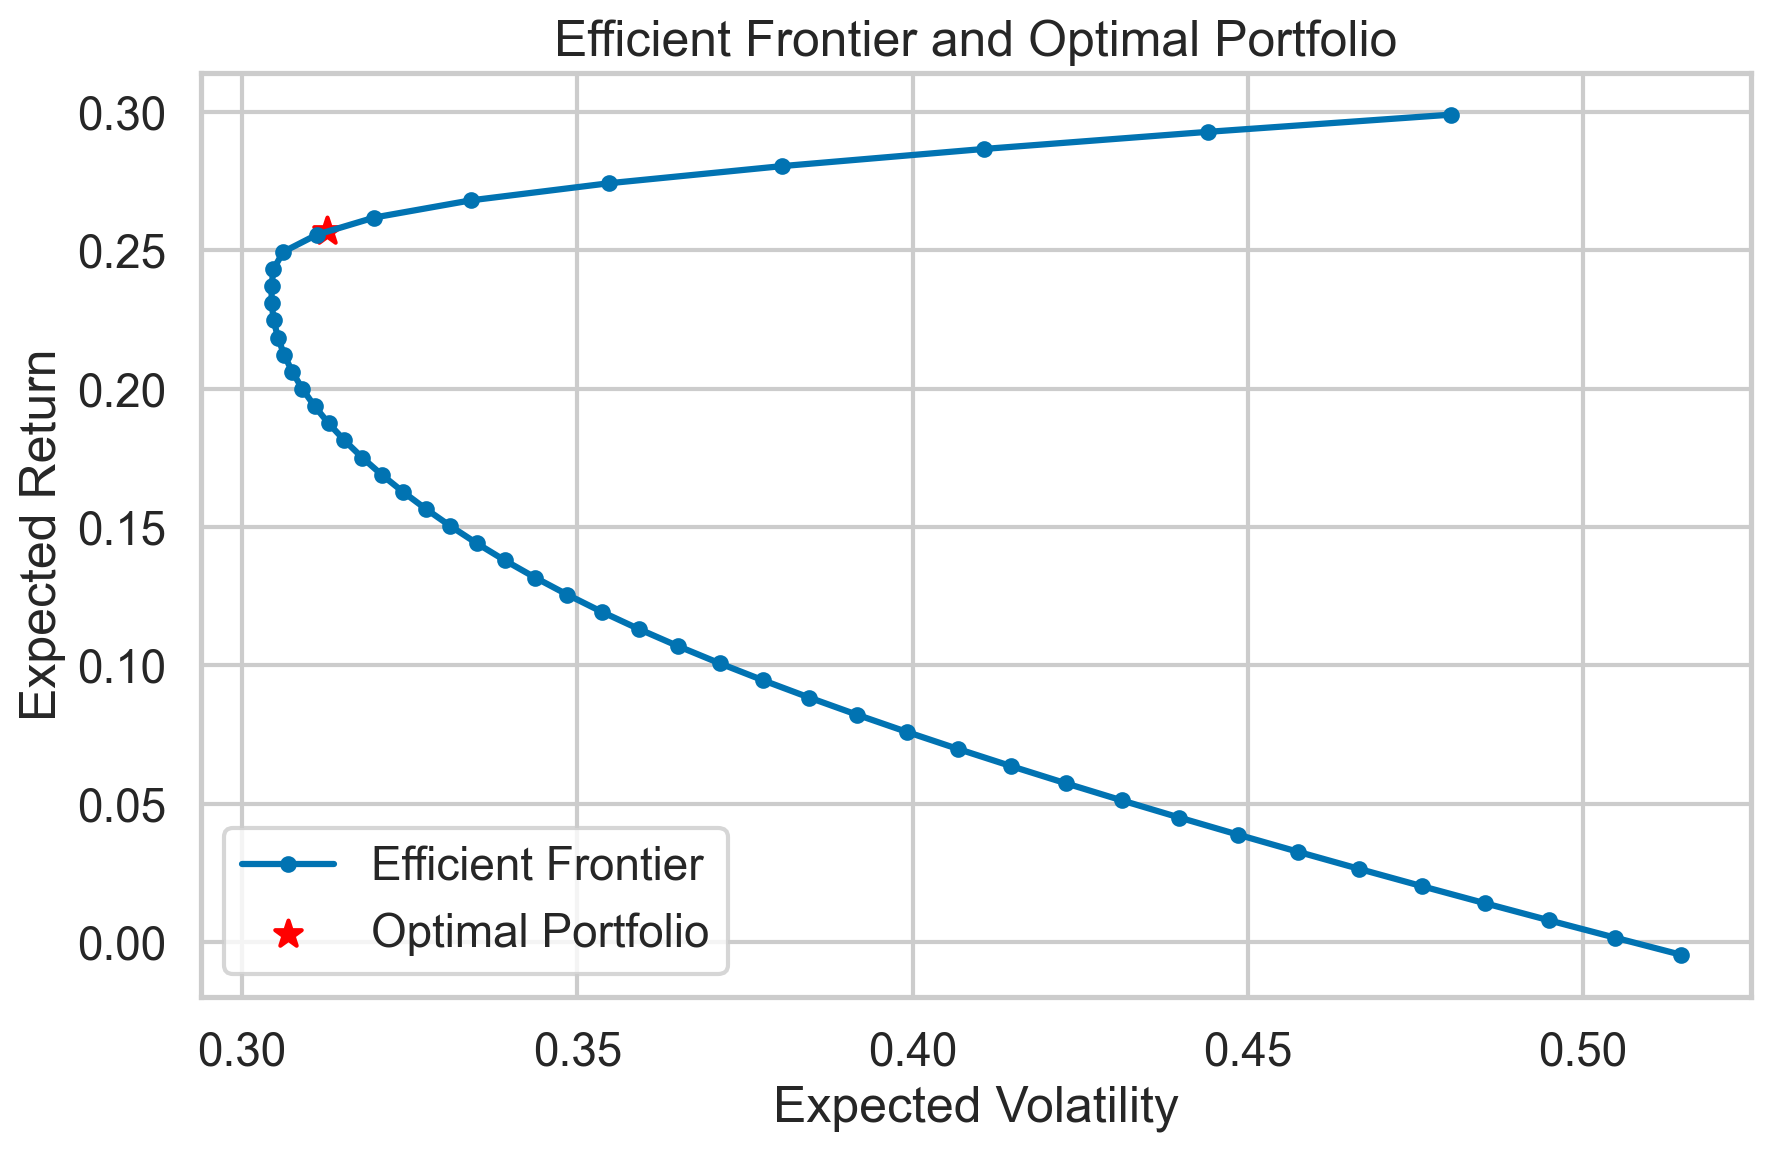

Optimal weights:  [0.         0.33368974 0.03506758 0.63124268]
Expected annual return: 0.26
Expected annual volatility: 0.31
Expected Sharpe Ratio: 0.82


In [8]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
import seaborn as sns
import yfinance as yf

# Fetching and preparing data
ASSETS = ["ALK", "GOOG", "COP", "F"]
prices_df = yf.download(ASSETS, start="2020-01-01", end="2023-12-31", auto_adjust=False)
returns = prices_df['Adj Close'].pct_change().dropna()

# Function to calculate portfolio statistics
def portfolio_stats(weights, returns):
    """
    Calculate portfolio statistics given asset weights and returns.
    """
    weights = np.array(weights)
    portfolio_return = np.dot(returns.mean(), weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return np.array([portfolio_return, portfolio_volatility, sharpe_ratio])

# Function to minimize for finding the minimum volatility
def minimize_volatility(weights, returns):
    """
    Minimize the volatility index to find the minimum volatility portfolio.
    """
    return portfolio_stats(weights, returns)[1]

# Function to maximize the Sharpe ratio
def negative_sharpe(weights, returns):
    """
    Maximize the Sharpe ratio by minimizing its negative value.
    """
    return -portfolio_stats(weights, returns)[2]

# Constraint for the weights to sum to 1
constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]

# Bounds for the weights (between 0 and 1 for each stock)
bounds = tuple((0, 1) for _ in ASSETS)
initial_guess = len(ASSETS) * [1. / len(ASSETS)]

# Range of target returns to find the efficient frontier
target_returns = np.linspace(returns.mean().min(), returns.mean().max(), 50) * 252
volatilities = []

# Calculating the efficient frontier
for tr in target_returns:
    # Define the constraint for this specific target return
    target_return_constraint = {'type': 'eq', 'fun': lambda x: portfolio_stats(x, returns)[0] - tr}
    all_constraints = constraints + [target_return_constraint]  # combine the list of constraints

    # Minimize volatility to find optimal weights for this target return
    result = sco.minimize(minimize_volatility, initial_guess, args=(returns,), method='SLSQP', bounds=bounds, constraints=all_constraints)
    volatilities.append(result.fun)

# Finding the optimal portfolio
opt_result = sco.minimize(negative_sharpe, initial_guess, args=(returns,), method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = opt_result.x
opt_return, opt_vol, opt_sharpe = portfolio_stats(optimal_weights, returns)

# Plotting the efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(volatilities, target_returns, 'b-o', markersize=5, label='Efficient Frontier')
plt.scatter(opt_vol, opt_return, color='red', s=100, marker='*', label='Optimal Portfolio')
plt.title('Efficient Frontier and Optimal Portfolio')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()

# Display the optimal weights and their portfolio stats
print("Optimal weights: ", optimal_weights)
print(f"Expected annual return: {opt_return:.2f}")
print(f"Expected annual volatility: {opt_vol:.2f}")
print(f"Expected Sharpe Ratio: {opt_sharpe:.2f}")

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set up visualization settings and ignore warnings
%matplotlib inline
%config InlineBackend.figure_format = "retina"
sns.set_theme(context="talk", style="whitegrid", palette="colorblind", rc={"figure.figsize": [12, 8]})
import warnings
from pandas.errors import SettingWithCopyWarning

# Ignore FutureWarning and SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Define the assets
ASSETS = ["ALK", "GOOG", "COP", "F"]

# Fetch data from Yahoo Finance for the specified assets and time period
data = yf.download(ASSETS, start="2020-01-01", end="2023-12-31", auto_adjust=False)['Adj Close']

# Determine the first Fridays for each month from 2020 to 2023
all_dates = pd.date_range(start="2020-01-01", end="2023-12-31", freq='B')
first_fridays = all_dates[(all_dates.weekday == 4) & (all_dates.is_month_start)]
monthly_data = data.loc[data.index.intersection(first_fridays)]

# Calculate monthly returns for the training data
monthly_returns = monthly_data.pct_change().dropna()

# Calculate expected returns and covariance matrix from these monthly returns
expected_returns = monthly_returns.mean()
covariance_matrix = monthly_returns.cov()

# Display training results
print("Expected Returns:\n", expected_returns)
print("\nCovariance Matrix:\n", covariance_matrix)

# Testing Phase: Apply the weights to the data from 2024
test_data = yf.download(ASSETS, start="2024-01-01", end=datetime.today().strftime('%Y-%m-%d'), auto_adjust=False)['Adj Close']
test_data = test_data.loc[test_data.index.intersection(first_fridays)]

# Define optimal weights
optimal_weights = np.array([0.358, 4.51028104e-17, 0.641, 0.0])

# Calculate returns on the test data
if not test_data.empty:
    test_returns = test_data.pct_change().dropna()
    portfolio_returns = (test_returns * optimal_weights).sum(axis=1)

    # Calculate cumulative returns
    cumulative_returns = (1 + portfolio_returns).cumprod()

    # Plot the cumulative returns
    plt.figure(figsize=(12, 8))
    plt.plot(cumulative_returns.index, cumulative_returns, marker='o', linestyle='-', markersize=5, label='Portfolio Cumulative Returns')
    plt.title('Portfolio Cumulative Returns from Jan 2024 to Present')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    sns.despine()
    plt.show()
else:
    print("No data available for the specified first Fridays.")

[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Expected Returns:
 Ticker
ALK     0.134724
COP     0.328330
F       0.365238
GOOG    0.220332
dtype: float64

Covariance Matrix:
 Ticker       ALK       COP         F      GOOG
Ticker                                        
ALK     0.284057  0.183758  0.460632  0.264086
COP     0.183758  0.164584  0.320177  0.183607
F       0.460632  0.320177  0.761143  0.432259
GOOG    0.264086  0.183607  0.432259  0.252929
No data available for the specified first Fridays.


[*********************100%%**********************]  4 of 4 completed


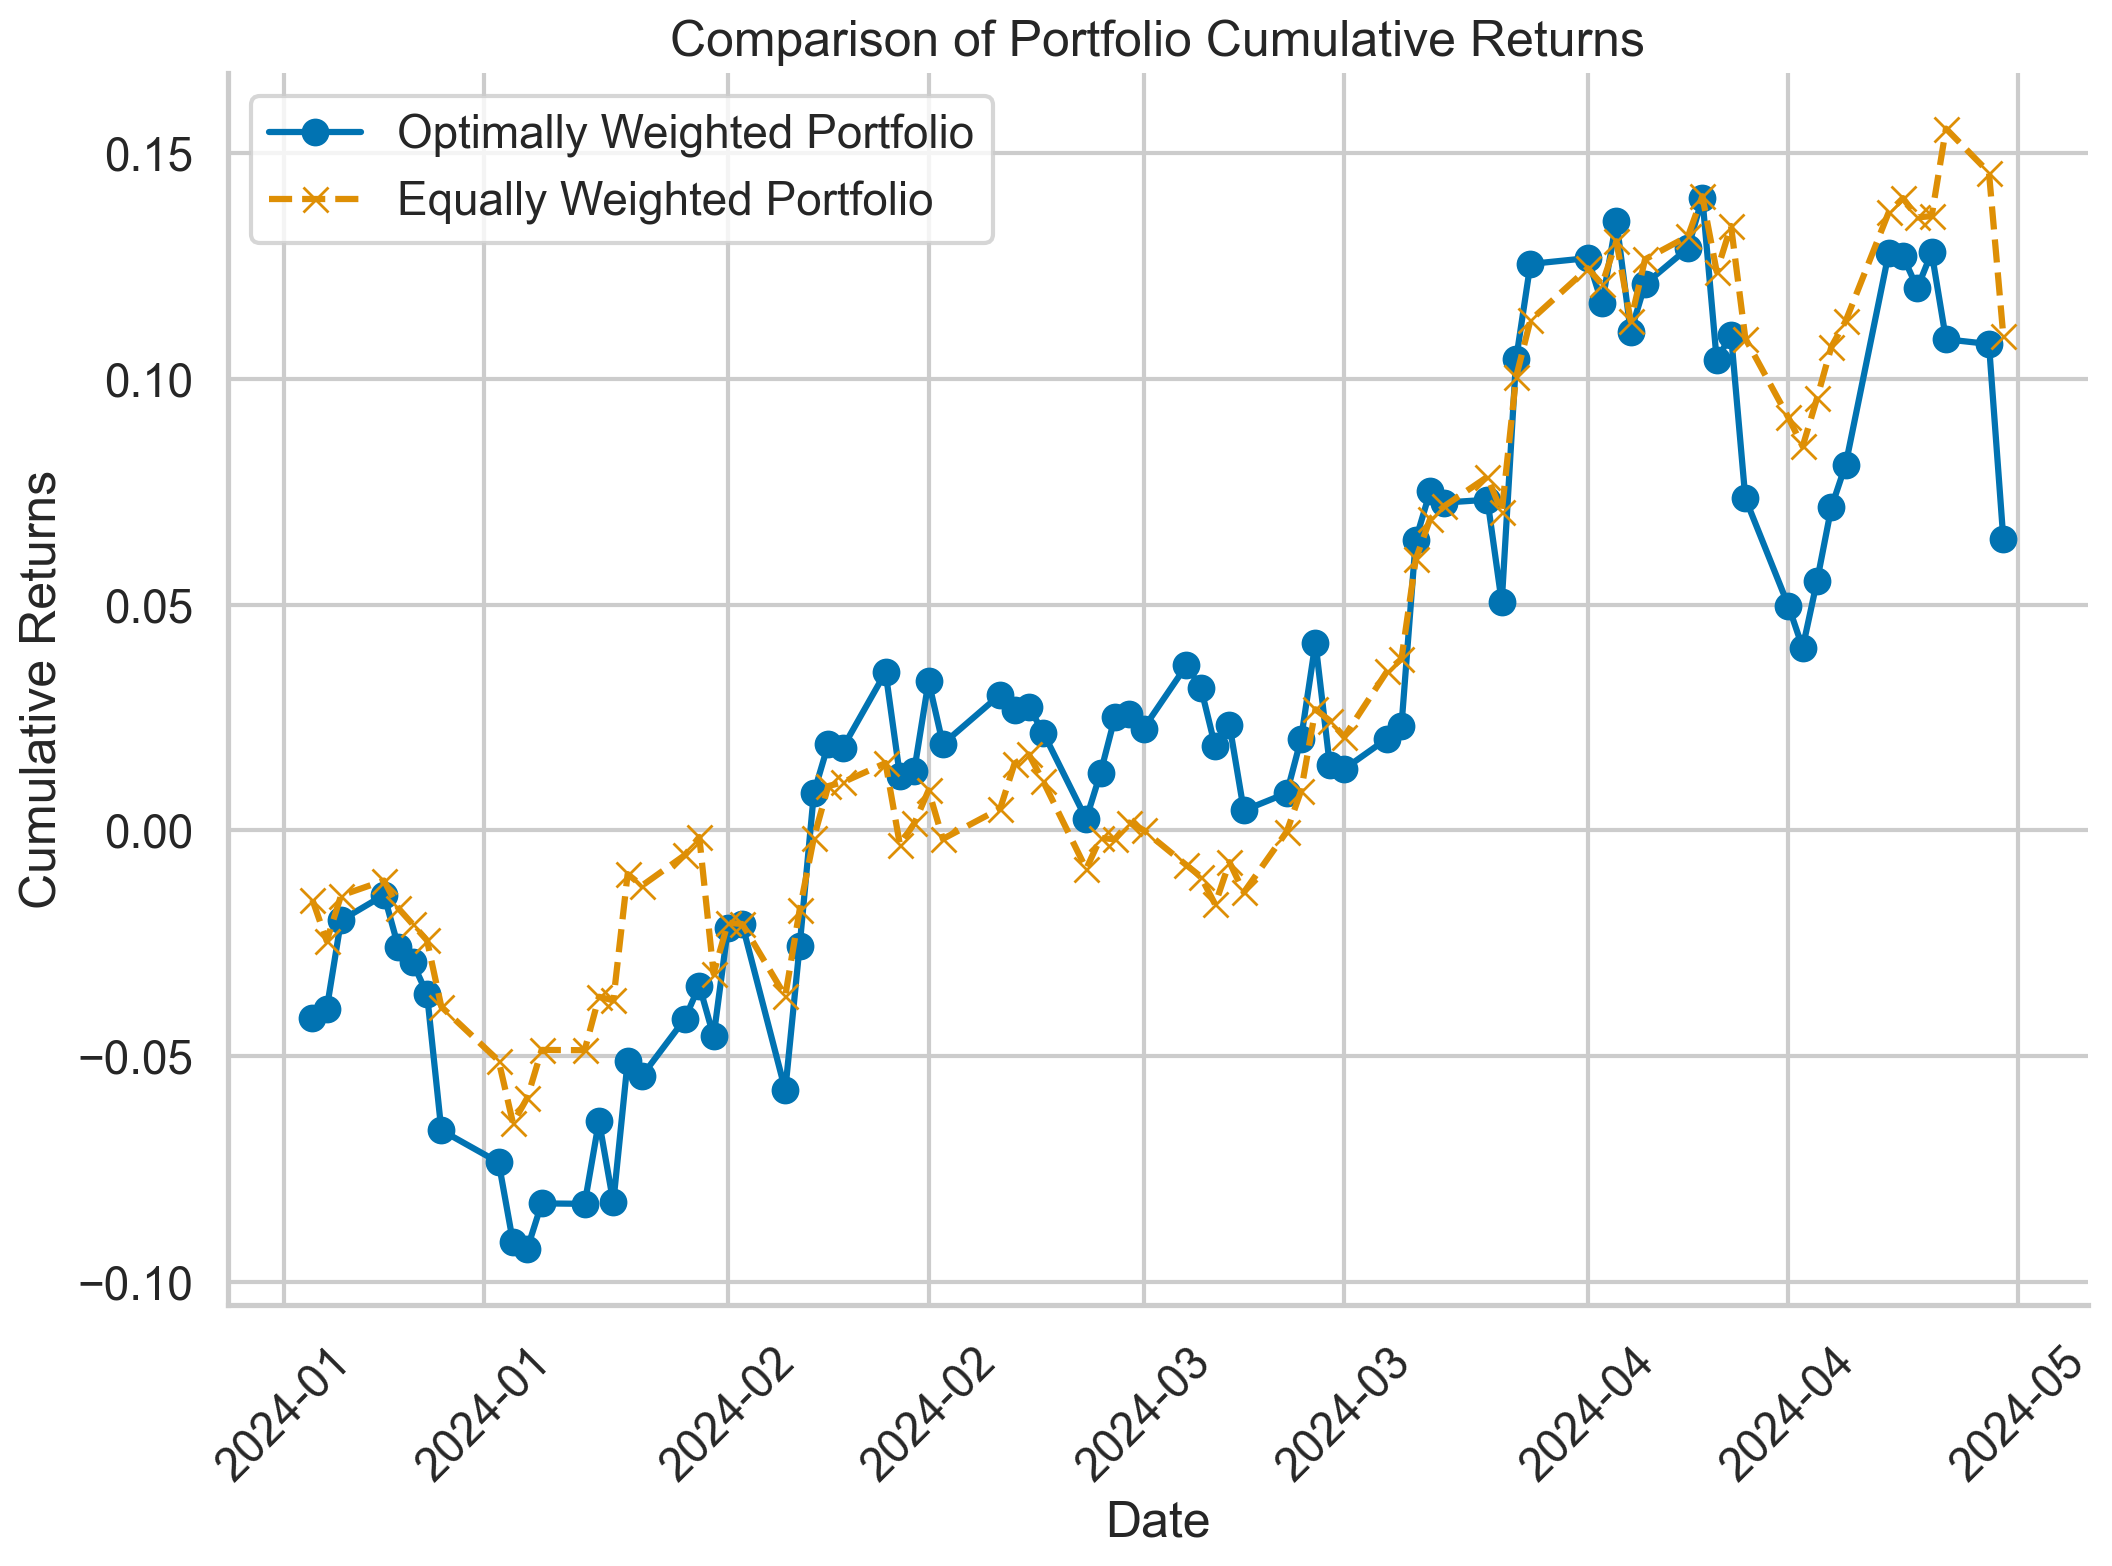

In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set up visualization settings and ignore warnings
sns.set_theme(context="talk", style="whitegrid", palette="colorblind", rc={"figure.figsize": [12, 8]})
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Define the assets
ASSETS = ["ALK", "GOOG", "COP", "F"]
start_date = "2024-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

# Download adjusted close prices for the test period
data = yf.download(ASSETS, start=start_date, end=end_date, auto_adjust=False)['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Define optimal and equal weights from your analysis
optimal_weights = np.array([0.358, 0.0, 0.642, 0.0])  # Optimal weights
equal_weights = np.array([0.25, 0.25, 0.25, 0.25])              # Equal weights

# Calculate portfolio returns using the weights
portfolio_optimal_returns = np.dot(returns, optimal_weights)
portfolio_equal_returns = np.dot(returns, equal_weights)

# Calculate cumulative returns
cumulative_optimal = (1 + portfolio_optimal_returns).cumprod() - 1
cumulative_equal = (1 + portfolio_equal_returns).cumprod() - 1

# Convert cumulative returns to Pandas Series
cumulative_optimal_series = pd.Series(cumulative_optimal, index=returns.index)
cumulative_equal_series = pd.Series(cumulative_equal, index=returns.index)

# Plot cumulative returns
plt.figure(figsize=(12, 8))
plt.plot(cumulative_optimal_series.index, cumulative_optimal_series, label='Optimally Weighted Portfolio', marker='o', linestyle='-')
plt.plot(cumulative_equal_series.index, cumulative_equal_series, label='Equally Weighted Portfolio', marker='x', linestyle='--')
plt.title('Comparison of Portfolio Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
sns.despine()

# Format x-axis tick marks to display month and year
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

